"Carga datos del Censo INE 1996"
Datos censales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from functions.cargar_data import *
from functions.func_demograficas import *
from functions.graficas import *

from scipy.optimize import curve_fit

In [2]:
# setea metadatos
metadatos_figs = {'Author': '''Guillermo D'Angelo'''}

# setea tipo de fuente y tamaño
size, font, font_legend = size_font()

# tamaño de las gráficas (pulgadas)
fig_size = [4, 2.4]

# ancho de las barras
bars_width=0.40

# colores
rosado  = (0.90, 0.40, 0.56)
oscuro  = (0.08, 0.02, 0.13)
violeta = (0.31, 0.11, 0.45)
salmon  = (0.98, 0.80, 0.67)
fucsia  = (0.72, 0.20, 0.58)
lista_colores = rosado, oscuro
color = 'darkcyan'
color_spines = 'grey'

def format_legend(x_pos, y_pos, labels):
    fig.legend( labels,
               bbox_to_anchor=(x_pos, y_pos),
               loc='upper right',
               frameon=False,
               labelspacing=1,
               prop=font_legend)

### Carga datos

In [3]:
# Matriz de distancias deptos
md = cargar_matriz_distancias()

def categorizar_dist(df):
    bins = [0, 100000, 200000, 300000, 400000, 500000, 700000]
    bin_indices = np.digitize(df.distancia.values, bins)
    return bin_indices

md['categoria_dist'] = categorizar_dist(md)

md.head(2)

,cod_ori,cod_des,cod,distancia,categoria_dist
0,1,2,102,610726,6
1,1,3,103,22544,1


In [4]:
# Matriz de distancias localidades
md_loc = cargar_matriz_dist_loc()
md_loc.head(2)

,cod_ori,cod_des,cod,distancia_m
0,2220,2521,22202521,137927
1,2220,2522,22202522,111408


In [5]:
# censo 96
censo96 = cargar_censo_96()
censo96.shape

(3163763, 13)

In [6]:
# migrantes internos censo 2011
p_migr = cargar_migrantes_internos()

### Pre-proceso censo 96

In [7]:
# crea tabla de flujos
dict_rename= {'HAC5DEPC': 'depto_origen',
              'DPTO':'depto_destino',
              'LOC': 'loc_destino',
              'HAC5LOC': 'loc_origen',
              'SEXO': 'sexo',
              'EDAD': 'edad'}

censo96.rename(dict_rename, axis=1, inplace=True)

flujos_deptos96 = censo96.loc[(censo96.HACE5AQUI.isnull()) & (censo96.depto_origen <= 19)]

flujos_deptos96 = flujos_deptos96.loc[flujos_deptos96.depto_destino != flujos_deptos96.depto_origen]\
                  .reset_index(drop=True)

flujos_deptos96['personas_mig'] = 1
flujos_deptos96['depto_origen'] = flujos_deptos96['depto_origen'].astype(int)

def codif_diada_depto(df):
    "Codifica díadas por departamento"
    cod_depto_destino_str = df['depto_destino'].astype(str).str.zfill(2)
    cod_diada_depto = (df['depto_origen'].astype(str) + cod_depto_destino_str).astype(int)
    return cod_diada_depto

# inserta el dato de díada codificada
flujos_deptos96.insert(0, 'cod', codif_diada_depto(flujos_deptos96))

print(flujos_deptos96.shape)
flujos_deptos96.head(2)

(193567, 15)


,cod,depto_destino,loc_destino,SECC,SEGM,VIVIENDA,TIPVIV,HOGARVIV,PARENTESCO,sexo,edad,HACE5AQUI,depto_origen,loc_origen,personas_mig
0,1301,1,20,1,1,36375,2,1,8,2,24,NaN,13,522.0,1
1,601,1,20,1,1,146352,2,1,10,1,51,NaN,6,220.0,1


In [8]:
def agrupar_y_recuperar_distancias(df, matriz_distancias):
    df_agrupado =  df.groupby(by=['cod', 'depto_origen', 'depto_destino']).sum()['personas_mig'].reset_index()
    df_agrupado['personas_mig'] = df_agrupado['personas_mig'].astype(int)
    df_dist = df_agrupado.merge(matriz_distancias.loc[:,['cod','distancia','categoria_dist']])
    
    return df_dist

df_96_dist = agrupar_y_recuperar_distancias(flujos_deptos96, md)
print(df_96_dist.shape[0])
df_96_dist.head(2)

342


,cod,depto_origen,depto_destino,personas_mig,distancia,categoria_dist
0,102,1,2,1277,610726,6
1,103,1,3,41077,22544,1


### Pre-proceso censo 2011

In [9]:
# censo 2011
dict_rename= {'PERNA01': 'edad', 'PERPH02':'sexo'}

censo11 = p_migr.rename(dict_rename, axis=1)

flujos_deptos11 = censo11

flujos_deptos11 = flujos_deptos11[flujos_deptos11.depto_origen != flujos_deptos11.depto_destino]

flujos_deptos11['personas_mig'] = 1

flujos_deptos11.insert(0, 'cod', codif_diada_depto(flujos_deptos11))

flujos_deptos11.head(2)

,cod,depto_origen,depto_destino,LOC,SECC,SEGM,VIVID,TIPO_VIVIE,HOGCOD,HOGID,...,PERED03_2,PERED04_R,PERED05_R,PERED06_R,CODIGO_CAR,PERED08,NIVELEDU_R,loc_origen,loc_destino,personas_mig
0,301,3,1,20,1,1,5,1,102001001000501,1,...,0,2,3,4,55131,1,9,3732,1020,1
1,1701,17,1,20,1,1,30,1,102001001003001,1,...,0,0,2,4,55152,1,9,17220,1020,1


In [10]:
df_11_dist = agrupar_y_recuperar_distancias(flujos_deptos11, md)
print(df_11_dist.shape[0])
df_11_dist.head(2)

342


,cod,depto_origen,depto_destino,personas_mig,distancia,categoria_dist
0,102,1,2,914,610726,6
1,103,1,3,33127,22544,1


#### Gráficas

In [11]:
def format_ticks(color, font,):
    "Formatea ticks"
    plt.xticks(**font, color=color)
    plt.yticks(**font, color=color)
    plt.tick_params(axis='y', color=color)
    plt.tick_params(axis='x', color=color) 

# Gráfico de flujos contra distancia
def plot_mig_distance(df, max_x, interval_x, name):
    f, ax = plt.subplots(1, figsize=(8,4))

    # plot de los puntos
    ax.scatter(df['distancia']/1000, df['personas_mig'], marker='.', color='k')

    # linea roja
    ax.plot([0, max_x], [0,0],  color='r')
    ax.plot([0, 0], [0, max(df['personas_mig'])+1],  color='r')
    
    # hide spines
    hide_spines(ax)
    ax.spines.left.set_position(('axes', 0.03))

    # Etiquetas
    ax.set_ylabel('Total de flujos', **font, color=color_spines)
    ax.set_xlabel('Distancia (km)', **font, color=color_spines)
    format_ticks(color_spines, font)
    
    save_chart(name, metadatos_figs)
    
    plt.show()

Flujos vs. distancia con Mvdeo. 1996

Se guardó la gráfica en mapas_graficas/003_eda_flujos_vs_distancia_1996.pdf


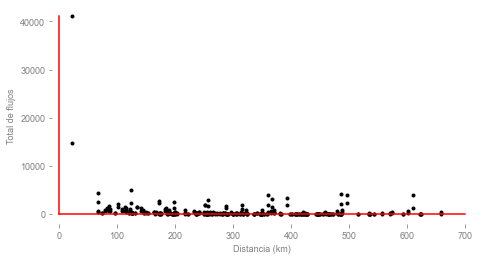

In [12]:
plot_mig_distance(df_96_dist, 700, 100, '003_eda_flujos_vs_distancia_1996.pdf')

Flujos vs. distancia sin Mvdeo. 1996

Se guardó la gráfica en mapas_graficas/003_eda_flujos_vs_distancia_1996_noMVO.pdf


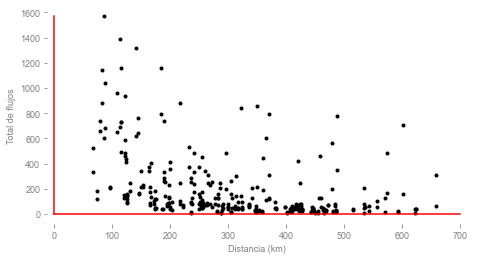

In [13]:
df_96_dist_no_mvo = df_96_dist.loc[(df_96_dist.depto_origen!=1) & (df_96_dist.depto_destino!=1)]
plot_mig_distance(df_96_dist_no_mvo, 700, 100, '003_eda_flujos_vs_distancia_1996_noMVO.pdf')

Flujos vs. distancia con Mvdeo. 2011

Se guardó la gráfica en mapas_graficas/003_eda_flujos_vs_distancia_2011.pdf


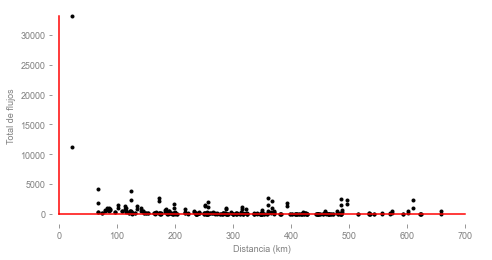

In [14]:
plot_mig_distance(df_11_dist, 700, 100, '003_eda_flujos_vs_distancia_2011.pdf')

Flujos vs. distancia sin Mvdeo. 2011

Se guardó la gráfica en mapas_graficas/003_eda_flujos_vs_distancia_2011_noMVO.pdf


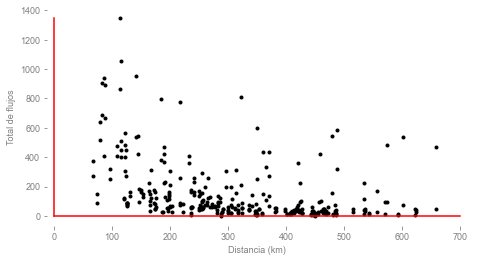

In [15]:
df_11_dist_no_mvo = df_11_dist.loc[(df_11_dist.depto_origen!=1) & (df_11_dist.depto_destino!=1)]
plot_mig_distance(df_11_dist_no_mvo, 700, 100, '003_eda_flujos_vs_distancia_2011_noMVO.pdf')

In [16]:
# sumatoria de distancias ponderadas
print('Sumatoria de distancias ponderadas, Censo 1996: ', round(sum(df_96_dist.distancia/df_96_dist.personas_mig)))
print('Sumatoria de distancias ponderadas, Censo 2011: ', round(sum(df_11_dist.distancia/df_11_dist.personas_mig)))

Sumatoria de distancias ponderadas, Censo 1996:  2336582
Sumatoria de distancias ponderadas, Censo 2011:  3145201


In [17]:
# sumatoria de distancias ponderadas sin Mvdeo.
print('Sumatoria distancia sin Mvdeo., Censo 1996: ', round(sum(df_96_dist_no_mvo.distancia/df_96_dist_no_mvo.personas_mig)))
print('Sumatoria distancia sin Mvdeo., Censo 2011: ', round(sum(df_11_dist_no_mvo.distancia/df_11_dist_no_mvo.personas_mig)))

Sumatoria distancia sin Mvdeo., Censo 1996:  2331553
Sumatoria distancia sin Mvdeo., Censo 2011:  3138065


#### Distancia mediana

In [18]:
mediana96 = np.median((df_96_dist_no_mvo['personas_mig'] * df_96_dist_no_mvo['distancia']/1000).values)
print('Mediana de personas migrantes internas por distancia en Censo 1996: ',  round(mediana96))

Mediana de personas migrantes internas por distancia en Censo 1996:  23076


In [19]:
mediana11 = np.median((df_11_dist_no_mvo['personas_mig'] * df_11_dist_no_mvo['distancia']/1000).values)
print('Mediana de personas migrantes internas por distancia en Censo 2011: ',  round(mediana11))

Mediana de personas migrantes internas por distancia en Censo 2011:  19670


In [20]:
def calc_cats(df):
    "Agrupa por categorías y calcula el porcentaje de cada una."
    cat = df.groupby('categoria_dist').sum()['personas_mig'].to_frame().reset_index()
    cat['porc'] = (cat.personas_mig / cat.personas_mig.sum())*100
    return cat

porc96 = calc_cats(df_96_dist)
porc11 = calc_cats(df_11_dist)

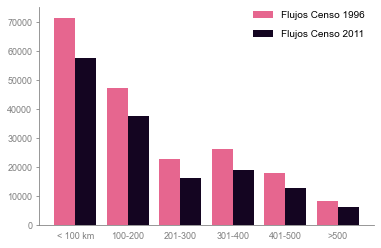

In [21]:
p96 = porc96.personas_mig.values
p11 = porc11.personas_mig.values
    
labels = ['< 100 km', '100-200', '201-300', '301-400', '401-500', '>500']
x = np.arange(len(labels))  # the label locations
    
width = 0.40  # the width of the bars
_labels = ['Flujos Censo 1996', 'Flujos Censo 2011']
color_spines = 'grey'

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, p96, width, label='Flujos Censo 1996', color=rosado)
rects2 = ax.bar(x + width/2, p11, width, label='Flujos Censo 2011', color=oscuro)

hide_spines(ax, todos=False)

format_spines(color_spines, ax)

plt.xticks(x, labels=labels, **font, color=color_spines)
plt.yticks(**font, color=color_spines)

plt.tick_params(axis='y',color=color_spines)
plt.tick_params(axis='x', bottom=False, labelbottom=True, color=color_spines) 

format_legend(0.9, 0.9, _labels)

plt.show()

fig.savefig('mapas_graficas/' + 'flujos_censo96vs2011_absolutos.pdf',
             bbox_inches= 'tight',
             metadata= metadatos_figs)

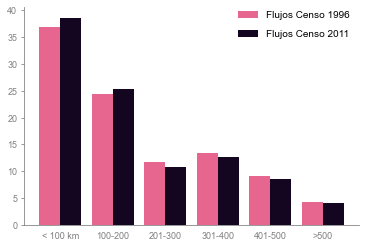

In [22]:
p96 = porc96.porc.values
p11 = porc11.porc.values
    
labels = ['< 100 km', '100-200', '201-300', '301-400', '401-500', '>500']
x = np.arange(len(labels))  # the label locations
    
width = 0.40  # the width of the bars
_labels = ['Flujos Censo 1996', 'Flujos Censo 2011']
color_spines = 'grey'

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, p96, width, label='Flujos Censo 1996', color=rosado)
rects2 = ax.bar(x + width/2, p11, width, label='Flujos Censo 2011', color=oscuro)

hide_spines(ax, todos=False)

format_spines(color_spines, ax)

plt.xticks(x, labels=labels, **font, color=color_spines)
plt.yticks(**font, color=color_spines)
plt.tick_params(axis='y', color=color_spines)
plt.tick_params(axis='x', bottom=False, labelbottom=True, color=color_spines) 

format_legend(0.9, 0.9, _labels)

plt.show()

fig.savefig('mapas_graficas/' + 'flujos_censo96vs2011_porcentajes.pdf',
             bbox_inches= 'tight',
             metadata= metadatos_figs)

In [23]:
def func(x, a, b) :
    return a * np.power(x, b)

def fit_plot(x, y, curve_color, point_color, name):
    fig, ax = plt.subplots()
    popt, pcov = curve_fit(func, x, y, maxfev=5000)  
    plt.plot(np.sort(x), func(np.sort(x), *popt), '-', color=curve_color, linewidth=2)
    plt.plot(x, y, '.', color=point_color, markersize=4)
    format_spines(color_spines, ax)
    plt.xticks(**font, color=color_spines)
    plt.yticks(**font, color=color_spines)
    plt.tick_params(axis='y',color=color_spines)
    plt.tick_params(axis='x', bottom=False, labelbottom=True, color=color_spines)
    hide_spines(ax, todos=False)
    [ax.spines[x].set_color(color_spines) for x in ["bottom", "left"]]

    plt.savefig('mapas_graficas/' + name,
             bbox_inches= 'tight',
             metadata= metadatos_figs)
    
    return plt.show()

In [24]:
x96 = df_96_dist_no_mvo['distancia'].values/1000
y96 = df_96_dist_no_mvo['personas_mig'].values

x11 = df_11_dist_no_mvo['distancia'].values/1000
y11 = df_11_dist_no_mvo['personas_mig'].values

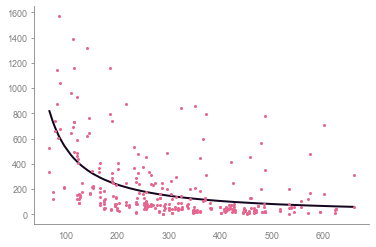

In [25]:
fit_plot(x96, y96, oscuro, rosado, 'curva_scatter_1996.pdf')

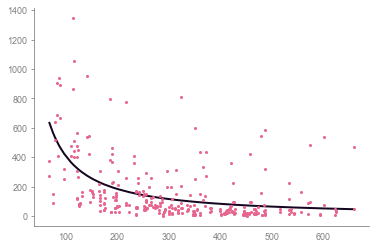

In [26]:
fit_plot(x11, y11, oscuro, rosado, 'curva_scatter_2011.pdf')

In [27]:
def fitted_curves_plot(x1, y1, x2, y2):
    popt1, pcov1 = curve_fit(func, x1, y1, maxfev=5000)  
    plt.plot(np.sort(x1), func(np.sort(x1), *popt1), '-')
    
    popt2, pcov2 = curve_fit(func, x2, y2, maxfev=5000)  
    plt.plot(np.sort(x2), func(np.sort(x2), *popt2), '-')
    
    return plt.show()

In [28]:
def fitted_curves_plot(x1, y1, x2, y2, curve_colors, name):
    fig, ax = plt.subplots()
    
    popt1, pcov1 = curve_fit(func, x1, y1, maxfev=5000)  
    plt.plot(np.sort(x1), func(np.sort(x1), *popt1), '-', color=curve_colors[0], linewidth=2)
    
    popt2, pcov2 = curve_fit(func, x2, y2, maxfev=5000)  
    plt.plot(np.sort(x2), func(np.sort(x2), *popt2), '-', color=curve_colors[1], linewidth=2)
    
    format_spines(color_spines, ax)
    
    plt.xticks(**font, color=color_spines)
    plt.yticks(**font, color=color_spines)
    plt.tick_params(axis='y',color=color_spines)
    plt.tick_params(axis='x', bottom=False, labelbottom=True, color=color_spines)
    hide_spines(ax, todos=False)
    [ax.spines[x].set_color(color_spines) for x in ["bottom", "left"]]

    plt.savefig('mapas_graficas/' + name,
             bbox_inches= 'tight',
             metadata= metadatos_figs)
    
    return plt.show()

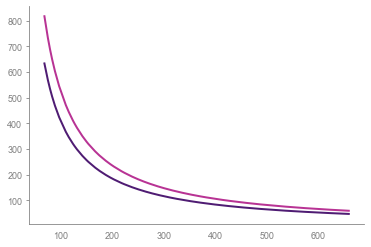

In [29]:
fitted_curves_plot(x96, y96, x11, y11, [fucsia, violeta], 'comp_curvas.pdf')

## Distancias contra edades y sexos

### Censo 2011

In [30]:
flujos_deptos11.head(2)

,cod,depto_origen,depto_destino,LOC,SECC,SEGM,VIVID,TIPO_VIVIE,HOGCOD,HOGID,...,PERED03_2,PERED04_R,PERED05_R,PERED06_R,CODIGO_CAR,PERED08,NIVELEDU_R,loc_origen,loc_destino,personas_mig
0,301,3,1,20,1,1,5,1,102001001000501,1,...,0,2,3,4,55131,1,9,3732,1020,1
1,1701,17,1,20,1,1,30,1,102001001003001,1,...,0,0,2,4,55152,1,9,17220,1020,1


In [31]:
def agrupacion_por_edad(df, matriz_distancias, columna_edad, filtro_edad):
    "Calcula promedio de distancia y migrante interno por edad"
    
    ag =  df.merge(matriz_distancias, how='left', on='cod', indicator=True) \
            .groupby(columna_edad) \
            .sum()[['personas_mig', 'distancia']].reset_index()
    
    ag['dist_prom'] = round(ag.distancia/1000/ag.personas_mig, 1)
    ag = ag.loc[ag[columna_edad] < filtro_edad]
    
    return ag

In [32]:
dist_11 = agrupacion_por_edad(flujos_deptos11, md, 'edad', 90)
dist_96 = agrupacion_por_edad(flujos_deptos96, md, 'edad', 90)

dist_11.head(2)

,edad,personas_mig,distancia,dist_prom
0,5.0,2661,483842661,181.8
1,6.0,2432,437912394,180.1


In [33]:
mediana96 = np.median(dist_96.dist_prom.values)
mediana11 = np.median(dist_11.dist_prom.values)

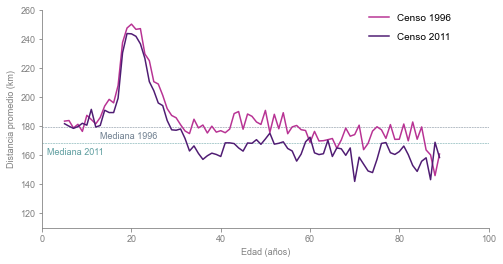

In [34]:
fig, ax = plt.subplots(figsize=(8,4))
# plot de medianas
def plot_linea(data, color):
    ax.plot([0, 100], [data, data], '--', color=color, linewidth=0.5)

plot_linea(mediana96, 'slategrey')
plot_linea(mediana11, 'cadetblue')

# plotea etiquetas de medianas
ax.text(13, mediana96 * 0.955, 'Mediana 1996', **font, color='slategrey', label='_nolegend_')
ax.text(1,  mediana11 * 0.955, 'Mediana 2011', **font, color='cadetblue', label='_nolegend_')

# plot de curvas
ax.plot(dist_96.edad, dist_96['dist_prom'], color=fucsia, label='Censo 1996')
ax.plot(dist_11.edad, dist_11['dist_prom'], color=violeta, label='Censo 2011')

# spines
format_spines(color_spines, ax)
ax.spines.left.set_position('zero')
format_ticks(color_spines, font)

# etiquetas
def labeling():
    ax.set_ylabel("Distancia promedio (km)", **font, color=color_spines)
    ax.set_xlabel("Edad (años)", **font, color=color_spines)
    
labeling()

ax.set_ylim(110, 260)
ax.set_xlim(0, 100)
    
fig.legend(bbox_to_anchor=(0.85, 0.9),loc='upper right',frameon=False,labelspacing=1, prop=font_legend)
    
plt.show()

fig.savefig('mapas_graficas/003_eda_edad_vs_distancia.pdf',
             bbox_inches= 'tight',
             metadata= metadatos_figs)

In [35]:
def agrupacion_por_edad_y_sexo(df, matriz_distancias, col_edad, col_sexo, filtro_edad):
    "Calcula promedio de distancia y migrante interno por edad"
    df = df.loc[df[col_edad] < filtro_edad]
    
    ag =  df.merge(matriz_distancias, how='left', on='cod', indicator=True) \
            .groupby([col_edad, col_sexo]) \
            .sum()[['personas_mig', 'distancia']].reset_index()
    
    ag['dist_prom'] = round(ag.distancia/1000/ag.personas_mig, 1)
    
    return ag

In [36]:
dist_96 = agrupacion_por_edad_y_sexo(flujos_deptos96, md, 'edad', 'sexo', 90)
dist_11 = agrupacion_por_edad_y_sexo(flujos_deptos11, md, 'edad', 'sexo', 90)

In [37]:
def filter_edad_sexo(df, sexo):
    "Filtra DF por sexo"
    edades  = df.loc[df.sexo==sexo, 'edad']
    n = df.loc[df.sexo==sexo, 'dist_prom']
    return edades, n

def plot_lines_comparativa(df, etiqueta, name):
    fig, ax = plt.subplots(figsize=(8,4))

    edades_mujeres, mujeres = filter_edad_sexo(df, 2)
    edades_varones, varones = filter_edad_sexo(df, 1)

    ax.plot(edades_mujeres, mujeres, color='cadetblue', label='Mujeres ' + etiqueta)
    ax.plot(edades_varones, varones, color='green', label='Varones ' + etiqueta)

    # hide spines
    format_spines(color_spines, ax)
    hide_spines(ax, todos=False)
    format_ticks(color_spines, font)

    # etiquetas
    ax.set_ylabel("Distancia promedio (km)", **font, color=color_spines)
    ax.set_xlabel("Edad (años)", **font, color=color_spines)

    ax.set_ylim(110, 260)
    ax.set_xlim(0, 100)
    
    fig.legend(bbox_to_anchor=(0.85, 0.9),loc='upper right',frameon=False,labelspacing=1,prop=font_legend)

    plt.show()

    fig.savefig('mapas_graficas/' + name,
                 bbox_inches= 'tight',
                 metadata= metadatos_figs)

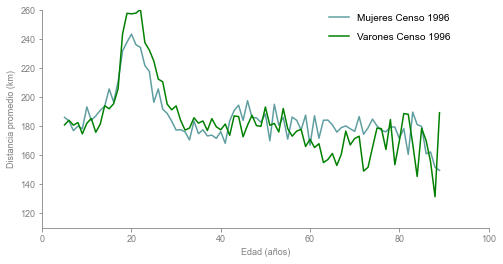

In [38]:
plot_lines_comparativa(dist_96, 'Censo 1996', '003_eda_edad_y_sexo_vs_distancia_1996.pdf')

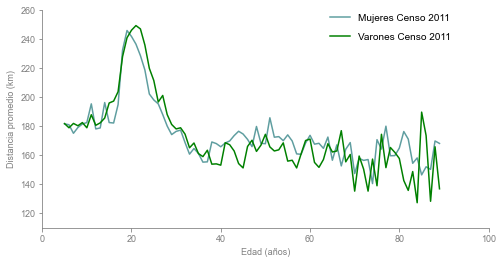

In [39]:
plot_lines_comparativa(dist_11, 'Censo 2011', '003_eda_edad_y_sexo_vs_distancia_2011.pdf')

In [40]:
def plot_lines_comparativa_censos(df96, df11, sexo):
    fig, ax = plt.subplots(1, figsize=(8,4))

    edades96, data96 = filter_edad_sexo(df96, sexo)
    edades11, data11 = filter_edad_sexo(df11, sexo)
    
    if sexo==1:
        texto_label='Varones '
    else:
        texto_label='Mujeres '

    ax.plot(edades96, data96, color=fucsia,  label= texto_label + '1996')
    ax.plot(edades11, data11, color=violeta, label= texto_label + '2011')

    # hide spines
    hide_spines(ax, todos=False)
    format_spines(color_spines, ax)
    format_ticks(color_spines, font)

    # etiquetas
    ax.set_ylabel("Distancia promedio (km)")
    ax.set_xlabel("Edad (años)")

    ax.set_ylim(110, 260)
    ax.set_xlim(0, 100)

    fig.legend(bbox_to_anchor=(0.85, 0.9),loc='upper right',frameon=False,labelspacing=1,prop=font_legend)

    plt.show()

#     fig.savefig('mapas_graficas/' + name,
#                  bbox_inches= 'tight',
#                  metadata= metadatos_figs)

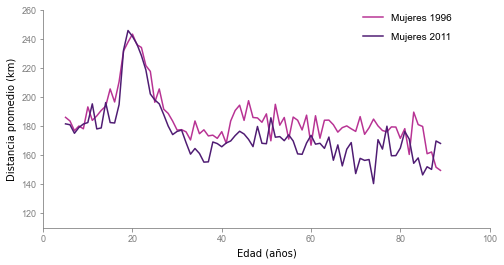

In [41]:
plot_lines_comparativa_censos(dist_96, dist_11, 2)

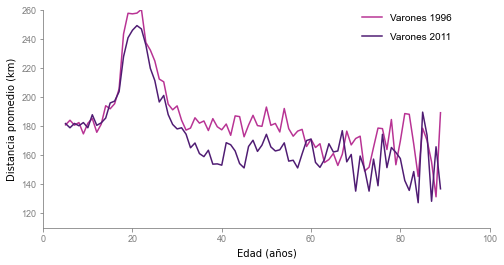

In [42]:
plot_lines_comparativa_censos(dist_96, dist_11, 1)